In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# OCLNN Model with 64 Channels

In [ ]:
# Import packages
import argparse
import sys
import numpy as np
# from OCLNN import OCLNN
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
#from tensorflow import set_random_seed
from sklearn.model_selection import *
# from utils import *
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from tensorflow.keras import *
from tensorflow.keras.regularizers import l2

## Load Data

In [ ]:
# Load Data
import pandas as pd
training_data = np.load("/content/drive/MyDrive/Thesis Project/Example_P300/Processed Data/BCI_IIb_training_data.npy")
training_labels = np.load("/content/drive/MyDrive/Thesis Project/Example_P300/Processed Data/BCI_IIb_training_label.npy")
testing_data = np.load("/content/drive/MyDrive/Thesis Project/Example_P300/Processed Data/BCI_IIb_testing_data.npy")
testing_labels = pd.DataFrame(np.load("/content/drive/MyDrive/Thesis Project/Example_P300/Processed Data/BCI_IIb_testing_label.npy", allow_pickle=True), 
                              columns=['epoch','row/column', 'true_character', 'true_character_index', 'P300_prob'])

subject = 0
print("Training data size: {0}".format(training_data.shape))
print("Testing data size: {0}".format(testing_data.shape))

Training data size: (1, 7560, 240, 64)
Testing data size: (5580, 240, 64)


In [ ]:
# Train test split
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(data[subject], labels[subject], test_size = 0.2, shuffle = True)
X_train, X_valid, y_train, y_valid = train_test_split(training_data[subject], training_labels[subject], test_size = 0.2, shuffle = True)

## Model Architecture

In [ ]:
K.clear_session()
model = models.Sequential()
model.add(layers.Input(shape = (240, 64)))
# model.add(layers.ZeroPadding1D(padding = 2))
model.add(layers.Conv1D(16, 16, strides = 16,
                          padding = 'valid',
                          data_format = 'channels_last',
                          kernel_initializer = 'glorot_uniform',
                          bias_initializer = 'zeros',
                          kernel_regularizer = 'l2',
                          bias_regularizer = 'l2',
                          use_bias = True))
# model.add(layers.Conv1D(16, kernel_size = (16,),strides = 16, activation='relu', input_shape=(240, 64)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(2, activation='softmax', kernel_regularizer= "l2", bias_regularizer= "l2"))
# model.add(layers.Dense(2, activation='softmax'))
model.add(layers.Flatten())

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 15, 16)            16400     
                                                                 
 dropout (Dropout)           (None, 15, 16)            0         
                                                                 
 flatten (Flatten)           (None, 240)               0         
                                                                 
 dense (Dense)               (None, 2)                 482       
                                                                 
 flatten_1 (Flatten)         (None, 2)                 0         
                                                                 
Total params: 16,882
Trainable params: 16,882
Non-trainable params: 0
_________________________________________________________________


## Run Model

In [ ]:
# Run the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

# class_weight = {0: 5, 1: 1}
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 50, restore_best_weights = True)
history = model.fit(X_train, to_categorical(y_train),batch_size = 256,epochs = 200,validation_data = (X_valid, to_categorical(y_valid)),callbacks = [es])
# history = model.fit(X_train, y_train, epochs= 150, batch_size = 128, validation_data= [X_test, y_test])

Epoch 1/200
24/24 [==============================] - 3s 78ms/step - loss: 1.1271 - accuracy: 0.6359 - val_loss: 0.8812 - val_accuracy: 0.7090
Epoch 2/200
24/24 [==============================] - 2s 73ms/step - loss: 0.7881 - accuracy: 0.7603 - val_loss: 0.7697 - val_accuracy: 0.7619
Epoch 3/200
24/24 [==============================] - 5s 203ms/step - loss: 0.6704 - accuracy: 0.8132 - val_loss: 0.6922 - val_accuracy: 0.8003
Epoch 4/200
24/24 [==============================] - 2s 77ms/step - loss: 0.6111 - accuracy: 0.8376 - val_loss: 0.6364 - val_accuracy: 0.8241
Epoch 5/200
24/24 [==============================] - 2s 70ms/step - loss: 0.5473 - accuracy: 0.8666 - val_loss: 0.5966 - val_accuracy: 0.8406
Epoch 6/200
24/24 [==============================] - 1s 40ms/step - loss: 0.5013 - accuracy: 0.8829 - val_loss: 0.5585 - val_accuracy: 0.8558
Epoch 7/200
24/24 [==============================] - 1s 40ms/step - loss: 0.4662 - accuracy: 0.8919 - val_loss: 0.5253 - val_accuracy: 0.8671
Epoch

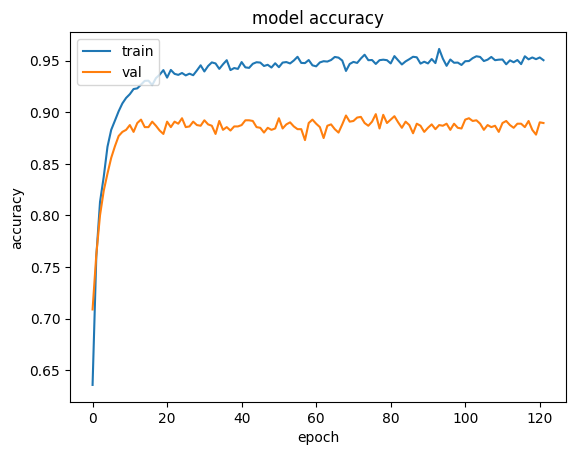

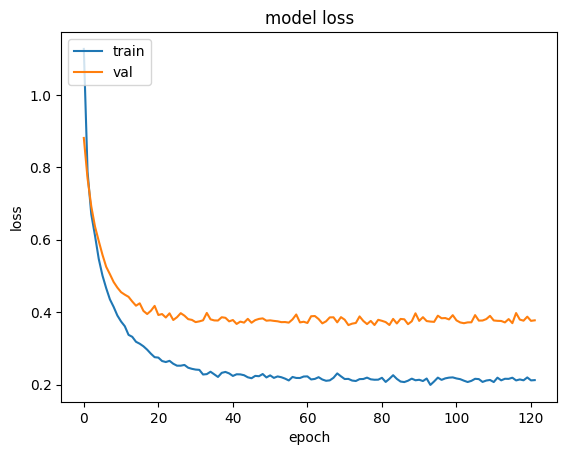

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_valid)

48/48 [==============================] - 0s 5ms/step


In [ ]:
from sklearn.metrics import accuracy_score
y_pred = np.argmax(y_pred, axis = 1)
accuracy_score(y_valid, y_pred)

0.8948412698412699

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_valid, y_pred)

array([[1203,   50],
       [ 109,  150]])

## Character spelling task

In [ ]:
# Plug in the predicted probability for intensification in each epoch
testing_labels['P300_prob'] = model.predict(testing_data)[:, 1]
testing_labels

175/175 [==============================] - 1s 3ms/step


,epoch,row/column,true_character,true_character_index,P300_prob
0,1,6,F,0,0.830940
1,1,12,F,0,0.000381
2,1,8,F,0,0.337276
3,1,3,F,0,0.018137
4,1,4,F,0,0.018578
...,...,...,...,...,...
5575,15,7,7,30,0.161297
5576,15,8,7,30,0.000787
5577,15,4,7,30,0.054845
5578,15,9,7,30,0.000006


In [ ]:
chara_map = {(7, 1): 'A', (7, 2): 'B', (7, 3): 'C', (7, 4): 'D', (7, 5): 'E', (7, 6): 'F',
 (8, 1): 'G', (8, 2): 'H', (8, 3): 'I', (8, 4): 'J', (8, 5): 'K', (8, 6): 'L', 
 (9, 1): 'M', (9, 2): 'N', (9, 3): 'O', (9, 4): 'P', (9, 5): 'Q', (9, 6): 'R',
 (10, 1): 'S',(10, 2): 'T', (10, 3): 'U', (10, 4): 'V', (10, 5): 'W', (10, 6): 'X',
 (11, 1): 'Y', (11, 2): 'Z', (11, 3): '1', (11, 4): '2', (11, 5): '3', (11, 6): '4',
 (12, 1): '5',(12, 2): '6', (12, 3): '7', (12, 4): '8', (12, 5): '9', (12, 6): '_'}

for spelling_epoch in range(1, 16):
    # print(testing_label[testing_label['epoch'] <= spelling_epoch].sort_values(['row/column', 'true_character_index']))
    filtered_testing_label = testing_labels[testing_labels['epoch'] <= spelling_epoch].groupby(['row/column', 'true_character', 'true_character_index'], as_index = False).sum()[['row/column','true_character', 'true_character_index', 'P300_prob']]
    # print(filtered_testing_label.sort_values(['row/column', 'true_character_index']))

    row_argmax = filtered_testing_label[filtered_testing_label['row/column'] > 6]
    # print(row_argmax[row_argmax['true_character'] == 'W'].sort_values(['true_character_index']))
    row_argmax = row_argmax.sort_values('P300_prob', ascending=False).drop_duplicates(['true_character', 'true_character_index'])
    # print(row_argmax.sort_values(['true_character_index']))
    row_argmax = row_argmax.rename(columns = {'row/column' : 'max_row_index'})

    # print(row_argmax.sort_values(['true_character_index']))

    col_argmax = filtered_testing_label[filtered_testing_label['row/column'] <= 6]
    col_argmax = col_argmax.sort_values('P300_prob', ascending=False).drop_duplicates(['true_character', 'true_character_index'])
    col_argmax = col_argmax.rename(columns = {'row/column' : 'max_col_index'})

    # print(col_argmax.sort_values(['true_character_index']))

    # print(pd.merge(row_argmax, col_argmax, on = ['true_character','true_character_index']))
    chara_df = pd.merge(row_argmax, col_argmax, on = ['true_character','true_character_index'])[['max_row_index', 'max_col_index', 'true_character','true_character_index']]
    # print(chara_df)
    chara_df['predicted_character'] = chara_df.apply(lambda x: chara_map[(x['max_row_index'], x['max_col_index'])], axis = 1)
    chara_df['check_character'] = chara_df.apply(lambda x: x['true_character'] == x['predicted_character'], axis = 1)
    # print(chara_df.sort_values(['true_character_index']))
    spelling_accuracy = chara_df['check_character'].mean()
    print('Character spelling accuracy with {0} epoches: {1}'.format(spelling_epoch, spelling_accuracy))

Character spelling accuracy with 1 epoches: 0.8387096774193549
Character spelling accuracy with 2 epoches: 0.8387096774193549
Character spelling accuracy with 3 epoches: 0.9032258064516129
Character spelling accuracy with 4 epoches: 0.9354838709677419
Character spelling accuracy with 5 epoches: 0.9354838709677419
Character spelling accuracy with 6 epoches: 0.967741935483871
Character spelling accuracy with 7 epoches: 0.967741935483871
Character spelling accuracy with 8 epoches: 1.0
Character spelling accuracy with 9 epoches: 1.0
Character spelling accuracy with 10 epoches: 1.0
Character spelling accuracy with 11 epoches: 1.0
Character spelling accuracy with 12 epoches: 1.0
Character spelling accuracy with 13 epoches: 1.0
Character spelling accuracy with 14 epoches: 1.0
Character spelling accuracy with 15 epoches: 1.0


# OCLNN Model with 8 channels

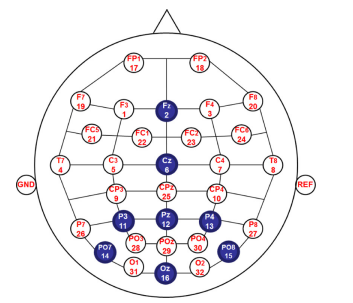

##Load Data

In [ ]:
import pandas as pd
training_data = np.load("/content/drive/MyDrive/Thesis Project/Example_P300/Processed Data/BCI_IIb_training_data.npy")
training_labels = np.load("/content/drive/MyDrive/Thesis Project/Example_P300/Processed Data/BCI_IIb_training_label.npy")
testing_data = np.load("/content/drive/MyDrive/Thesis Project/Example_P300/Processed Data/BCI_IIb_testing_data.npy")
testing_labels = pd.DataFrame(np.load("/content/drive/MyDrive/Thesis Project/Example_P300/Processed Data/BCI_IIb_testing_label.npy", allow_pickle=True), 
                              columns=['epoch','row/column', 'true_character', 'true_character_index', 'P300_prob'])

subject = 0
print("Training data size: {0}".format(training_data.shape))
print("Testing data size: {0}".format(testing_data.shape))

Training data size: (1, 7560, 240, 64)
Testing data size: (5580, 240, 64)


In [ ]:
training_data.shape

(1, 7560, 240, 64)

In [ ]:
testing_data.shape

(5580, 240, 64)

##Channel Subset Selection

In [ ]:
selected_channel = ['Fz', 'Cz', 'P3', 'Pz', 'P4', 'PO7', 'PO8', 'Oz']

all_channels = [ 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5',
                'C3',  'C1',  'Cz',  'C2',  'C4',  'C6',  'CP5', 'CP3',
                'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'Fp1', 'Fpz', 'Fp2',
                'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7',  'F5',  'F3',
                'F1',  'Fz',  'F2',  'F4',  'F6',  'F8',  'FT7', 'FT8',
                'T7',  'T8',  'T9',  'T10', 'TP7', 'TP8', 'P7',  'P5',
                'P3',  'P1',  'Pz',  'P2',  'P4',  'P6',  'P8',  'PO7',
                'PO3', 'POz', 'PO4', 'PO8', 'O1',  'Oz',  'O2',  'Iz' ] 

def Channel_Filter(all_channels, selected_channel, data):

  channel_index = [all_channels.index(channel) for channel in selected_channel]
  new_data = data[:, :, channel_index]

  # shape = (240, num_selected_channel)
  return new_data

Channel_Filter(all_channels, selected_channel, training_data[0]).shape
channel_8_training_data = np.expand_dims(Channel_Filter(all_channels, selected_channel, training_data[0]), axis=0)
channel_8_testing_data = Channel_Filter(all_channels, selected_channel, testing_data)

In [ ]:
channel_8_training_data.shape

(1, 7560, 240, 8)

In [ ]:
channel_8_testing_data.shape

(5580, 240, 8)

In [ ]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(data[subject], labels[subject], test_size = 0.2, shuffle = True)
X_train, X_valid, y_train, y_valid = train_test_split(channel_8_training_data[subject], training_labels[subject], test_size = 0.2, shuffle = True)

In [ ]:
print(X_train.shape)
print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)

(6048, 240, 8)
(6048,)


## Model Architecture

In [ ]:
K.clear_session()
model = models.Sequential()
model.add(layers.Input(shape = (240, 8)))
# model.add(layers.ZeroPadding1D(padding = 2))
model.add(layers.Conv1D(16, 16, strides = 16,
                          padding = 'valid',
                          data_format = 'channels_last',
                          kernel_initializer = 'glorot_uniform',
                          bias_initializer = 'zeros',
                          kernel_regularizer = 'l2',
                          bias_regularizer = 'l2',
                          use_bias = True))
# model.add(layers.Conv1D(16, kernel_size = (16,),strides = 16, activation='relu', input_shape=(240, 64)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(2, activation='softmax', kernel_regularizer= "l2", bias_regularizer= "l2"))
# model.add(layers.Dense(2, activation='softmax'))
model.add(layers.Flatten())

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 15, 16)            2064      
                                                                 
 dropout (Dropout)           (None, 15, 16)            0         
                                                                 
 flatten (Flatten)           (None, 240)               0         
                                                                 
 dense (Dense)               (None, 2)                 482       
                                                                 
 flatten_1 (Flatten)         (None, 2)                 0         
                                                                 
Total params: 2,546
Trainable params: 2,546
Non-trainable params: 0
_________________________________________________________________


## Run Model

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

# class_weight = {0: 5, 1: 1}
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 50, restore_best_weights = True)
history = model.fit(X_train, to_categorical(y_train),batch_size = 256,epochs = 200,validation_data = (X_valid, to_categorical(y_valid)),callbacks = [es])
# history = model.fit(X_train, y_train, epochs= 150, batch_size = 128, validation_data= [X_test, y_test])

Epoch 1/200
24/24 [==============================] - 1s 19ms/step - loss: 0.8561 - accuracy: 0.6128 - val_loss: 0.6498 - val_accuracy: 0.7540
Epoch 2/200
24/24 [==============================] - 0s 10ms/step - loss: 0.6552 - accuracy: 0.7434 - val_loss: 0.5646 - val_accuracy: 0.8042
Epoch 3/200
24/24 [==============================] - 0s 12ms/step - loss: 0.5597 - accuracy: 0.8062 - val_loss: 0.5060 - val_accuracy: 0.8353
Epoch 4/200
24/24 [==============================] - 0s 10ms/step - loss: 0.5026 - accuracy: 0.8381 - val_loss: 0.4621 - val_accuracy: 0.8585
Epoch 5/200
24/24 [==============================] - 0s 10ms/step - loss: 0.4666 - accuracy: 0.8560 - val_loss: 0.4311 - val_accuracy: 0.8743
Epoch 6/200
24/24 [==============================] - 0s 9ms/step - loss: 0.4345 - accuracy: 0.8697 - val_loss: 0.4072 - val_accuracy: 0.8770
Epoch 7/200
24/24 [==============================] - 0s 9ms/step - loss: 0.4183 - accuracy: 0.8733 - val_loss: 0.3922 - val_accuracy: 0.8796
Epoch 8/

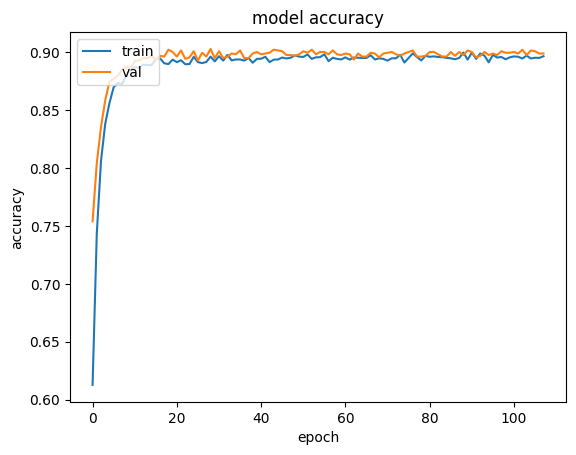

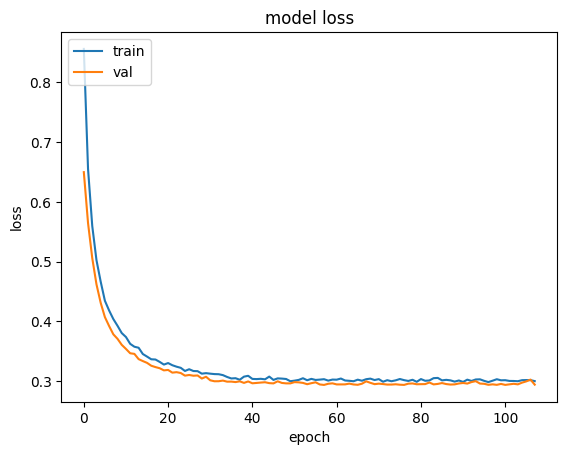

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
channel_8_testing_data.shape

(5580, 240, 8)

In [ ]:
testing_labels['P300_prob'] = model.predict(channel_8_testing_data)[:, 1]
testing_labels

175/175 [==============================] - 1s 3ms/step


,epoch,row/column,true_character,true_character_index,P300_prob
0,1,6,F,0,0.460250
1,1,12,F,0,0.014568
2,1,8,F,0,0.290271
3,1,3,F,0,0.112063
4,1,4,F,0,0.034496
...,...,...,...,...,...
5575,15,7,7,30,0.332552
5576,15,8,7,30,0.091438
5577,15,4,7,30,0.064321
5578,15,9,7,30,0.020245


## Character spelling task

In [ ]:
chara_map = {(7, 1): 'A', (7, 2): 'B', (7, 3): 'C', (7, 4): 'D', (7, 5): 'E', (7, 6): 'F',
 (8, 1): 'G', (8, 2): 'H', (8, 3): 'I', (8, 4): 'J', (8, 5): 'K', (8, 6): 'L', 
 (9, 1): 'M', (9, 2): 'N', (9, 3): 'O', (9, 4): 'P', (9, 5): 'Q', (9, 6): 'R',
 (10, 1): 'S',(10, 2): 'T', (10, 3): 'U', (10, 4): 'V', (10, 5): 'W', (10, 6): 'X',
 (11, 1): 'Y', (11, 2): 'Z', (11, 3): '1', (11, 4): '2', (11, 5): '3', (11, 6): '4',
 (12, 1): '5',(12, 2): '6', (12, 3): '7', (12, 4): '8', (12, 5): '9', (12, 6): '_'}

for spelling_epoch in range(1, 16):
    # print(testing_label[testing_label['epoch'] <= spelling_epoch].sort_values(['row/column', 'true_character_index']))
    filtered_testing_label = testing_labels[testing_labels['epoch'] <= spelling_epoch].groupby(['row/column', 'true_character', 'true_character_index'], as_index = False).sum()[['row/column','true_character', 'true_character_index', 'P300_prob']]
    # print(filtered_testing_label.sort_values(['row/column', 'true_character_index']))

    row_argmax = filtered_testing_label[filtered_testing_label['row/column'] > 6]
    # print(row_argmax[row_argmax['true_character'] == 'W'].sort_values(['true_character_index']))
    row_argmax = row_argmax.sort_values('P300_prob', ascending=False).drop_duplicates(['true_character', 'true_character_index'])
    # print(row_argmax.sort_values(['true_character_index']))
    row_argmax = row_argmax.rename(columns = {'row/column' : 'max_row_index'})

    # print(row_argmax.sort_values(['true_character_index']))

    col_argmax = filtered_testing_label[filtered_testing_label['row/column'] <= 6]
    col_argmax = col_argmax.sort_values('P300_prob', ascending=False).drop_duplicates(['true_character', 'true_character_index'])
    col_argmax = col_argmax.rename(columns = {'row/column' : 'max_col_index'})

    # print(col_argmax.sort_values(['true_character_index']))

    # print(pd.merge(row_argmax, col_argmax, on = ['true_character','true_character_index']))
    chara_df = pd.merge(row_argmax, col_argmax, on = ['true_character','true_character_index'])[['max_row_index', 'max_col_index', 'true_character','true_character_index']]
    # print(chara_df)
    chara_df['predicted_character'] = chara_df.apply(lambda x: chara_map[(x['max_row_index'], x['max_col_index'])], axis = 1)
    chara_df['check_character'] = chara_df.apply(lambda x: x['true_character'] == x['predicted_character'], axis = 1)
    # print(chara_df.sort_values(['true_character_index']))
    spelling_accuracy = chara_df['check_character'].mean()
    print('Character spelling accuracy with {0} epoches: {1}'.format(spelling_epoch, spelling_accuracy))

Character spelling accuracy with 1 epoches: 0.6774193548387096
Character spelling accuracy with 2 epoches: 0.7419354838709677
Character spelling accuracy with 3 epoches: 0.8709677419354839
Character spelling accuracy with 4 epoches: 0.967741935483871
Character spelling accuracy with 5 epoches: 0.967741935483871
Character spelling accuracy with 6 epoches: 0.9354838709677419
Character spelling accuracy with 7 epoches: 0.967741935483871
Character spelling accuracy with 8 epoches: 0.9354838709677419
Character spelling accuracy with 9 epoches: 1.0
Character spelling accuracy with 10 epoches: 1.0
Character spelling accuracy with 11 epoches: 1.0
Character spelling accuracy with 12 epoches: 1.0
Character spelling accuracy with 13 epoches: 1.0
Character spelling accuracy with 14 epoches: 1.0
Character spelling accuracy with 15 epoches: 1.0


# OCLNN Model with 4 channels

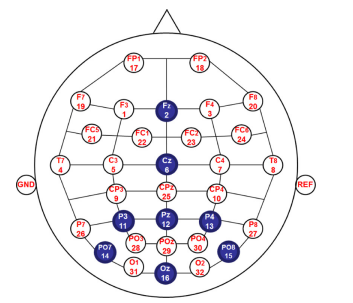

##Load Data

In [ ]:
import pandas as pd
training_data = np.load("/content/drive/MyDrive/Thesis Project/Example_P300/Processed Data/BCI_IIb_training_data.npy")
training_labels = np.load("/content/drive/MyDrive/Thesis Project/Example_P300/Processed Data/BCI_IIb_training_label.npy")
testing_data = np.load("/content/drive/MyDrive/Thesis Project/Example_P300/Processed Data/BCI_IIb_testing_data.npy")
testing_labels = pd.DataFrame(np.load("/content/drive/MyDrive/Thesis Project/Example_P300/Processed Data/BCI_IIb_testing_label.npy", allow_pickle=True), 
                              columns=['epoch','row/column', 'true_character', 'true_character_index', 'P300_prob'])

subject = 0
print("Training data size: {0}".format(training_data.shape))
print("Testing data size: {0}".format(testing_data.shape))

Training data size: (1, 7560, 240, 64)
Testing data size: (5580, 240, 64)


In [ ]:
training_data.shape

(1, 7560, 240, 64)

In [ ]:
testing_data.shape

(5580, 240, 64)

##Channel Subset Selection

In [ ]:
selected_channel = ['Pz', 'PO7', 'PO8', 'Oz']

all_channels = [ 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5',
                'C3',  'C1',  'Cz',  'C2',  'C4',  'C6',  'CP5', 'CP3',
                'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'Fp1', 'Fpz', 'Fp2',
                'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7',  'F5',  'F3',
                'F1',  'Fz',  'F2',  'F4',  'F6',  'F8',  'FT7', 'FT8',
                'T7',  'T8',  'T9',  'T10', 'TP7', 'TP8', 'P7',  'P5',
                'P3',  'P1',  'Pz',  'P2',  'P4',  'P6',  'P8',  'PO7',
                'PO3', 'POz', 'PO4', 'PO8', 'O1',  'Oz',  'O2',  'Iz' ] 

def Channel_Filter(all_channels, selected_channel, data):

  channel_index = [all_channels.index(channel) for channel in selected_channel]
  new_data = data[:, :, channel_index]

  # shape = (240, num_selected_channel)
  return new_data

Channel_Filter(all_channels, selected_channel, training_data[0]).shape
channel_4_training_data = np.expand_dims(Channel_Filter(all_channels, selected_channel, training_data[0]), axis=0)
channel_4_testing_data = Channel_Filter(all_channels, selected_channel, testing_data)

In [ ]:
channel_4_training_data.shape

(1, 7560, 240, 4)

In [ ]:
channel_4_testing_data.shape

(5580, 240, 4)

In [ ]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(data[subject], labels[subject], test_size = 0.2, shuffle = True)
X_train, X_valid, y_train, y_valid = train_test_split(channel_4_training_data[subject], training_labels[subject], test_size = 0.2, shuffle = True)

In [ ]:
print(X_train.shape)
print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)

(6048, 240, 4)
(6048,)


## Model Architecture

In [ ]:
K.clear_session()
model = models.Sequential()
model.add(layers.Input(shape = (240, 4)))
# model.add(layers.ZeroPadding1D(padding = 2))
model.add(layers.Conv1D(16, 16, strides = 16,
                          padding = 'valid',
                          data_format = 'channels_last',
                          kernel_initializer = 'glorot_uniform',
                          bias_initializer = 'zeros',
                          kernel_regularizer = 'l2',
                          bias_regularizer = 'l2',
                          use_bias = True))
# model.add(layers.Conv1D(16, kernel_size = (16,),strides = 16, activation='relu', input_shape=(240, 64)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(2, activation='softmax', kernel_regularizer= "l2", bias_regularizer= "l2"))
# model.add(layers.Dense(2, activation='softmax'))
model.add(layers.Flatten())

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 15, 16)            1040      
                                                                 
 dropout (Dropout)           (None, 15, 16)            0         
                                                                 
 flatten (Flatten)           (None, 240)               0         
                                                                 
 dense (Dense)               (None, 2)                 482       
                                                                 
 flatten_1 (Flatten)         (None, 2)                 0         
                                                                 
Total params: 1,522
Trainable params: 1,522
Non-trainable params: 0
_________________________________________________________________


## Run Model

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

# class_weight = {0: 5, 1: 1}
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 50, restore_best_weights = True)
history = model.fit(X_train, to_categorical(y_train),batch_size = 256,epochs = 200,validation_data = (X_valid, to_categorical(y_valid)),callbacks = [es])
# history = model.fit(X_train, y_train, epochs= 150, batch_size = 128, validation_data= [X_test, y_test])

Epoch 1/200
24/24 [==============================] - 2s 20ms/step - loss: 0.7757 - accuracy: 0.6101 - val_loss: 0.6410 - val_accuracy: 0.7222
Epoch 2/200
24/24 [==============================] - 0s 8ms/step - loss: 0.6196 - accuracy: 0.7497 - val_loss: 0.5529 - val_accuracy: 0.7870
Epoch 3/200
24/24 [==============================] - 0s 8ms/step - loss: 0.5443 - accuracy: 0.8029 - val_loss: 0.4801 - val_accuracy: 0.8366
Epoch 4/200
24/24 [==============================] - 0s 9ms/step - loss: 0.4762 - accuracy: 0.8424 - val_loss: 0.4241 - val_accuracy: 0.8638
Epoch 5/200
24/24 [==============================] - 0s 8ms/step - loss: 0.4274 - accuracy: 0.8628 - val_loss: 0.3924 - val_accuracy: 0.8770
Epoch 6/200
24/24 [==============================] - 0s 9ms/step - loss: 0.4080 - accuracy: 0.8661 - val_loss: 0.3737 - val_accuracy: 0.8803
Epoch 7/200
24/24 [==============================] - 0s 8ms/step - loss: 0.3893 - accuracy: 0.8729 - val_loss: 0.3590 - val_accuracy: 0.8843
Epoch 8/200


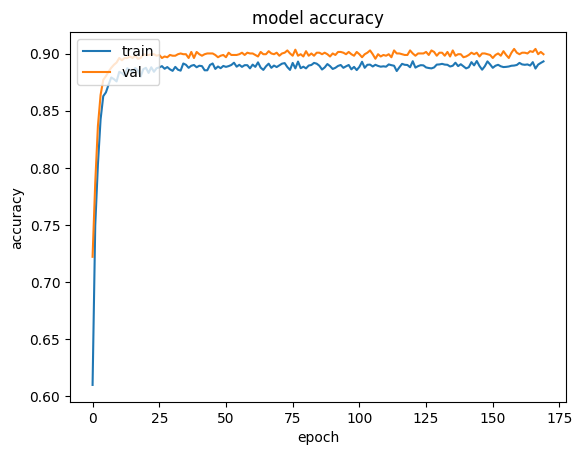

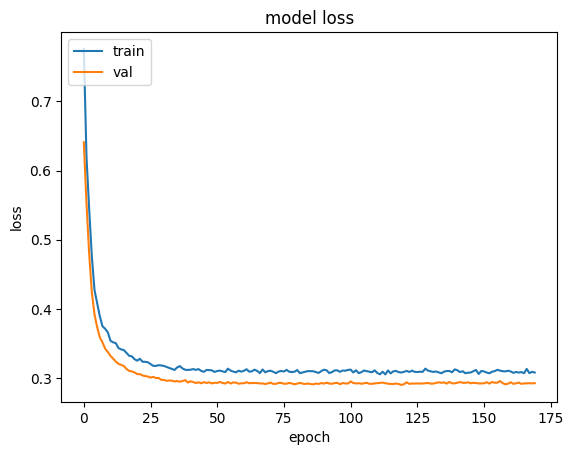

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
channel_4_testing_data.shape

(5580, 240, 4)

## Character spelling task

In [ ]:
testing_labels['P300_prob'] = model.predict(channel_4_testing_data)[:, 1]
testing_labels

175/175 [==============================] - 0s 2ms/step


,epoch,row/column,true_character,true_character_index,P300_prob
0,1,6,F,0,0.328117
1,1,12,F,0,0.029008
2,1,8,F,0,0.356734
3,1,3,F,0,0.060053
4,1,4,F,0,0.036883
...,...,...,...,...,...
5575,15,7,7,30,0.313326
5576,15,8,7,30,0.136846
5577,15,4,7,30,0.048978
5578,15,9,7,30,0.048300


In [ ]:
chara_map = {(7, 1): 'A', (7, 2): 'B', (7, 3): 'C', (7, 4): 'D', (7, 5): 'E', (7, 6): 'F',
 (8, 1): 'G', (8, 2): 'H', (8, 3): 'I', (8, 4): 'J', (8, 5): 'K', (8, 6): 'L', 
 (9, 1): 'M', (9, 2): 'N', (9, 3): 'O', (9, 4): 'P', (9, 5): 'Q', (9, 6): 'R',
 (10, 1): 'S',(10, 2): 'T', (10, 3): 'U', (10, 4): 'V', (10, 5): 'W', (10, 6): 'X',
 (11, 1): 'Y', (11, 2): 'Z', (11, 3): '1', (11, 4): '2', (11, 5): '3', (11, 6): '4',
 (12, 1): '5',(12, 2): '6', (12, 3): '7', (12, 4): '8', (12, 5): '9', (12, 6): '_'}

for spelling_epoch in range(1, 16):
    # print(testing_label[testing_label['epoch'] <= spelling_epoch].sort_values(['row/column', 'true_character_index']))
    filtered_testing_label = testing_labels[testing_labels['epoch'] <= spelling_epoch].groupby(['row/column', 'true_character', 'true_character_index'], as_index = False).sum()[['row/column','true_character', 'true_character_index', 'P300_prob']]
    # print(filtered_testing_label.sort_values(['row/column', 'true_character_index']))

    row_argmax = filtered_testing_label[filtered_testing_label['row/column'] > 6]
    # print(row_argmax[row_argmax['true_character'] == 'W'].sort_values(['true_character_index']))
    row_argmax = row_argmax.sort_values('P300_prob', ascending=False).drop_duplicates(['true_character', 'true_character_index'])
    # print(row_argmax.sort_values(['true_character_index']))
    row_argmax = row_argmax.rename(columns = {'row/column' : 'max_row_index'})

    # print(row_argmax.sort_values(['true_character_index']))

    col_argmax = filtered_testing_label[filtered_testing_label['row/column'] <= 6]
    col_argmax = col_argmax.sort_values('P300_prob', ascending=False).drop_duplicates(['true_character', 'true_character_index'])
    col_argmax = col_argmax.rename(columns = {'row/column' : 'max_col_index'})

    # print(col_argmax.sort_values(['true_character_index']))

    # print(pd.merge(row_argmax, col_argmax, on = ['true_character','true_character_index']))
    chara_df = pd.merge(row_argmax, col_argmax, on = ['true_character','true_character_index'])[['max_row_index', 'max_col_index', 'true_character','true_character_index']]
    # print(chara_df)
    chara_df['predicted_character'] = chara_df.apply(lambda x: chara_map[(x['max_row_index'], x['max_col_index'])], axis = 1)
    chara_df['check_character'] = chara_df.apply(lambda x: x['true_character'] == x['predicted_character'], axis = 1)
    # print(chara_df.sort_values(['true_character_index']))
    spelling_accuracy = chara_df['check_character'].mean()
    print('Character spelling accuracy with {0} epoches: {1}'.format(spelling_epoch, spelling_accuracy))

Character spelling accuracy with 1 epoches: 0.6129032258064516
Character spelling accuracy with 2 epoches: 0.7419354838709677
Character spelling accuracy with 3 epoches: 0.8387096774193549
Character spelling accuracy with 4 epoches: 1.0
Character spelling accuracy with 5 epoches: 0.967741935483871
Character spelling accuracy with 6 epoches: 0.9354838709677419
Character spelling accuracy with 7 epoches: 0.9354838709677419
Character spelling accuracy with 8 epoches: 0.967741935483871
Character spelling accuracy with 9 epoches: 1.0
Character spelling accuracy with 10 epoches: 1.0
Character spelling accuracy with 11 epoches: 1.0
Character spelling accuracy with 12 epoches: 1.0
Character spelling accuracy with 13 epoches: 1.0
Character spelling accuracy with 14 epoches: 1.0
Character spelling accuracy with 15 epoches: 1.0


# OCLNN Model with 1 channels

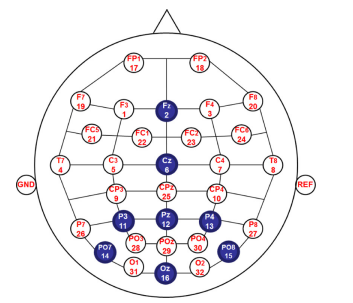

##Load Data

In [ ]:
import pandas as pd
training_data = np.load("/content/drive/MyDrive/Thesis Project/Example_P300/Processed Data/BCI_IIb_training_data.npy")
training_labels = np.load("/content/drive/MyDrive/Thesis Project/Example_P300/Processed Data/BCI_IIb_training_label.npy")
testing_data = np.load("/content/drive/MyDrive/Thesis Project/Example_P300/Processed Data/BCI_IIb_testing_data.npy")
testing_labels = pd.DataFrame(np.load("/content/drive/MyDrive/Thesis Project/Example_P300/Processed Data/BCI_IIb_testing_label.npy", allow_pickle=True), 
                              columns=['epoch','row/column', 'true_character', 'true_character_index', 'P300_prob'])

subject = 0
print("Training data size: {0}".format(training_data.shape))
print("Testing data size: {0}".format(testing_data.shape))

Training data size: (1, 7560, 240, 64)
Testing data size: (5580, 240, 64)


In [ ]:
training_data.shape

(1, 7560, 240, 64)

In [ ]:
testing_data.shape

(5580, 240, 64)

##Single Channel Selection

In [ ]:
selected_channel = ['PO7']

all_channels = [ 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5',
                'C3',  'C1',  'Cz',  'C2',  'C4',  'C6',  'CP5', 'CP3',
                'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'Fp1', 'Fpz', 'Fp2',
                'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7',  'F5',  'F3',
                'F1',  'Fz',  'F2',  'F4',  'F6',  'F8',  'FT7', 'FT8',
                'T7',  'T8',  'T9',  'T10', 'TP7', 'TP8', 'P7',  'P5',
                'P3',  'P1',  'Pz',  'P2',  'P4',  'P6',  'P8',  'PO7',
                'PO3', 'POz', 'PO4', 'PO8', 'O1',  'Oz',  'O2',  'Iz' ] 

def Channel_Filter(all_channels, selected_channel, data):

  channel_index = [all_channels.index(channel) for channel in selected_channel]
  new_data = data[:, :, channel_index]

  # shape = (240, num_selected_channel)
  return new_data

Channel_Filter(all_channels, selected_channel, training_data[0]).shape
channel_4_training_data = np.expand_dims(Channel_Filter(all_channels, selected_channel, training_data[0]), axis=0)
channel_4_testing_data = Channel_Filter(all_channels, selected_channel, testing_data)

In [ ]:
channel_4_training_data.shape

(1, 7560, 240, 1)

In [ ]:
channel_4_testing_data.shape

(5580, 240, 1)

In [ ]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(data[subject], labels[subject], test_size = 0.2, shuffle = True)
X_train, X_valid, y_train, y_valid = train_test_split(channel_4_training_data[subject], training_labels[subject], test_size = 0.2, shuffle = True)

In [ ]:
print(X_train.shape)
print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)

(6048, 240, 1)
(6048,)


## Model Architecture

In [ ]:
K.clear_session()
model = models.Sequential()
model.add(layers.Input(shape = (240, 1)))
# model.add(layers.ZeroPadding1D(padding = 2))
model.add(layers.Conv1D(16, 16, strides = 16,
                          padding = 'valid',
                          data_format = 'channels_last',
                          kernel_initializer = 'glorot_uniform',
                          bias_initializer = 'zeros',
                          kernel_regularizer = 'l2',
                          bias_regularizer = 'l2',
                          use_bias = True))
# model.add(layers.Conv1D(16, kernel_size = (16,),strides = 16, activation='relu', input_shape=(240, 64)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(2, activation='softmax', kernel_regularizer= "l2", bias_regularizer= "l2"))
# model.add(layers.Dense(2, activation='softmax'))
model.add(layers.Flatten())

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 15, 16)            272       
                                                                 
 dropout (Dropout)           (None, 15, 16)            0         
                                                                 
 flatten (Flatten)           (None, 240)               0         
                                                                 
 dense (Dense)               (None, 2)                 482       
                                                                 
 flatten_1 (Flatten)         (None, 2)                 0         
                                                                 
Total params: 754
Trainable params: 754
Non-trainable params: 0
_________________________________________________________________


## Run Model

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

# class_weight = {0: 5, 1: 1}
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 50, restore_best_weights = True)
history = model.fit(X_train, to_categorical(y_train),batch_size = 256,epochs = 200,validation_data = (X_valid, to_categorical(y_valid)),callbacks = [es])
# history = model.fit(X_train, y_train, epochs= 150, batch_size = 128, validation_data= [X_test, y_test])

Epoch 1/200
24/24 [==============================] - 1s 14ms/step - loss: 0.7409 - accuracy: 0.5815 - val_loss: 0.6500 - val_accuracy: 0.6911
Epoch 2/200
24/24 [==============================] - 0s 6ms/step - loss: 0.6086 - accuracy: 0.7416 - val_loss: 0.5457 - val_accuracy: 0.8049
Epoch 3/200
24/24 [==============================] - 0s 7ms/step - loss: 0.5266 - accuracy: 0.8156 - val_loss: 0.4876 - val_accuracy: 0.8347
Epoch 4/200
24/24 [==============================] - 0s 8ms/step - loss: 0.4942 - accuracy: 0.8302 - val_loss: 0.4700 - val_accuracy: 0.8399
Epoch 5/200
24/24 [==============================] - 0s 6ms/step - loss: 0.4818 - accuracy: 0.8318 - val_loss: 0.4609 - val_accuracy: 0.8373
Epoch 6/200
24/24 [==============================] - 0s 7ms/step - loss: 0.4760 - accuracy: 0.8309 - val_loss: 0.4545 - val_accuracy: 0.8373
Epoch 7/200
24/24 [==============================] - 0s 7ms/step - loss: 0.4691 - accuracy: 0.8315 - val_loss: 0.4504 - val_accuracy: 0.8366
Epoch 8/200


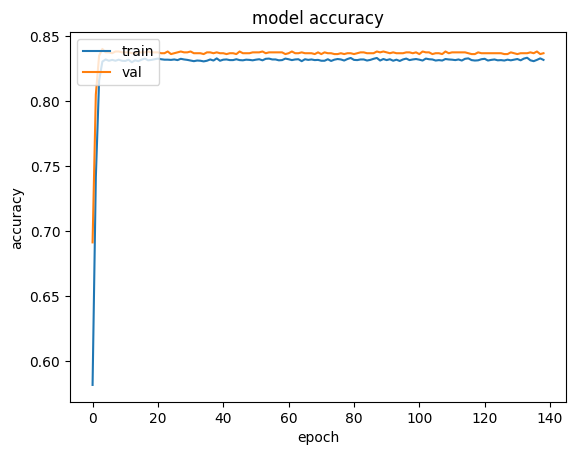

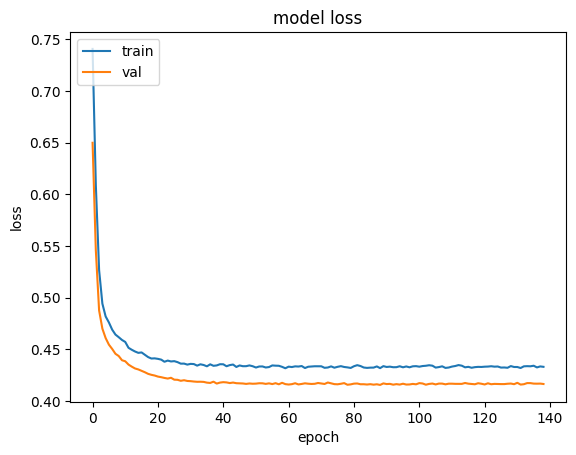

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
channel_4_testing_data.shape

(5580, 240, 1)

## Character spelling task

In [ ]:
testing_labels['P300_prob'] = model.predict(channel_4_testing_data)[:, 1]
testing_labels

175/175 [==============================] - 0s 1ms/step


,epoch,row/column,true_character,true_character_index,P300_prob
0,1,6,F,0,0.156985
1,1,12,F,0,0.192129
2,1,8,F,0,0.168913
3,1,3,F,0,0.227127
4,1,4,F,0,0.197814
...,...,...,...,...,...
5575,15,7,7,30,0.214266
5576,15,8,7,30,0.230259
5577,15,4,7,30,0.090760
5578,15,9,7,30,0.080166


In [ ]:
chara_map = {(7, 1): 'A', (7, 2): 'B', (7, 3): 'C', (7, 4): 'D', (7, 5): 'E', (7, 6): 'F',
 (8, 1): 'G', (8, 2): 'H', (8, 3): 'I', (8, 4): 'J', (8, 5): 'K', (8, 6): 'L', 
 (9, 1): 'M', (9, 2): 'N', (9, 3): 'O', (9, 4): 'P', (9, 5): 'Q', (9, 6): 'R',
 (10, 1): 'S',(10, 2): 'T', (10, 3): 'U', (10, 4): 'V', (10, 5): 'W', (10, 6): 'X',
 (11, 1): 'Y', (11, 2): 'Z', (11, 3): '1', (11, 4): '2', (11, 5): '3', (11, 6): '4',
 (12, 1): '5',(12, 2): '6', (12, 3): '7', (12, 4): '8', (12, 5): '9', (12, 6): '_'}

for spelling_epoch in range(1, 16):
    # print(testing_label[testing_label['epoch'] <= spelling_epoch].sort_values(['row/column', 'true_character_index']))
    filtered_testing_label = testing_labels[testing_labels['epoch'] <= spelling_epoch].groupby(['row/column', 'true_character', 'true_character_index'], as_index = False).sum()[['row/column','true_character', 'true_character_index', 'P300_prob']]
    # print(filtered_testing_label.sort_values(['row/column', 'true_character_index']))

    row_argmax = filtered_testing_label[filtered_testing_label['row/column'] > 6]
    # print(row_argmax[row_argmax['true_character'] == 'W'].sort_values(['true_character_index']))
    row_argmax = row_argmax.sort_values('P300_prob', ascending=False).drop_duplicates(['true_character', 'true_character_index'])
    # print(row_argmax.sort_values(['true_character_index']))
    row_argmax = row_argmax.rename(columns = {'row/column' : 'max_row_index'})

    # print(row_argmax.sort_values(['true_character_index']))

    col_argmax = filtered_testing_label[filtered_testing_label['row/column'] <= 6]
    col_argmax = col_argmax.sort_values('P300_prob', ascending=False).drop_duplicates(['true_character', 'true_character_index'])
    col_argmax = col_argmax.rename(columns = {'row/column' : 'max_col_index'})

    # print(col_argmax.sort_values(['true_character_index']))

    # print(pd.merge(row_argmax, col_argmax, on = ['true_character','true_character_index']))
    chara_df = pd.merge(row_argmax, col_argmax, on = ['true_character','true_character_index'])[['max_row_index', 'max_col_index', 'true_character','true_character_index']]
    # print(chara_df)
    chara_df['predicted_character'] = chara_df.apply(lambda x: chara_map[(x['max_row_index'], x['max_col_index'])], axis = 1)
    chara_df['check_character'] = chara_df.apply(lambda x: x['true_character'] == x['predicted_character'], axis = 1)
    # print(chara_df.sort_values(['true_character_index']))
    spelling_accuracy = chara_df['check_character'].mean()
    print('Character spelling accuracy with {0} epoches: {1}'.format(spelling_epoch, spelling_accuracy))

Character spelling accuracy with 1 epoches: 0.06451612903225806
Character spelling accuracy with 2 epoches: 0.03225806451612903
Character spelling accuracy with 3 epoches: 0.0967741935483871
Character spelling accuracy with 4 epoches: 0.0967741935483871
Character spelling accuracy with 5 epoches: 0.16129032258064516
Character spelling accuracy with 6 epoches: 0.12903225806451613
Character spelling accuracy with 7 epoches: 0.1935483870967742
Character spelling accuracy with 8 epoches: 0.16129032258064516
Character spelling accuracy with 9 epoches: 0.25806451612903225
Character spelling accuracy with 10 epoches: 0.2903225806451613
Character spelling accuracy with 11 epoches: 0.25806451612903225
Character spelling accuracy with 12 epoches: 0.3548387096774194
Character spelling accuracy with 13 epoches: 0.1935483870967742
Character spelling accuracy with 14 epoches: 0.2903225806451613
Character spelling accuracy with 15 epoches: 0.25806451612903225
